In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_validate
from sklearn.metrics import  recall_score,roc_auc_score, roc_curve
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from sklearn.tree import DecisionTreeClassifier
import warnings
import itertools
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv('data.csv',index_col=0)

# Cleaning
By inspecting the values in the different columns we noticed some irregular values especially in the gender and diff_sym_hos columns.

In [3]:
#Negative hours changed to positive
for i in range(len(df)):
    df.iloc[i, 12] = df.iloc[i, 12] * -1 if df.iloc[i, 12] < 0 else df.iloc[i, 12]

#Gender value 2 changed to the most common gender
df['gender'] = df['gender'].mask(df['gender'] == 2, 1)

# Helper Methods
These methods will be used to perform different operations such as encoding the data. As well as splitting the dataframe to train, test, and validation sets.

In [4]:
# Splits the given dataframe into 70% training set, 15% validation set, 15% testing set
def split(df):
    x = df.drop('result', axis=1)
    y = df['result']
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3,shuffle=True, random_state=42, stratify=y)
    X_validate, X_test, y_validate, y_test = train_test_split(X_test, y_test, test_size=0.5,shuffle=True, random_state=42, stratify=y_test)
    return X_train, X_validate, X_test, y_train, y_validate, y_test

In [5]:
# one hot encoding
def encode(df, columns):
    df_encoded = df.copy()
    for col in columns:
        encoding = pd.get_dummies(df[col], prefix=col)
        df_encoded = df_encoded.join(encoding)
        df_encoded.drop(col, axis=1, inplace=True)
    return df_encoded


This method will take the training and validation data, perform hyperparameter tuning and evaluate based on the best recall from the different models for SVM.

In [6]:
def svm_validate(X_train, y_train, X_validate, y_validate):
    dic = {'clf':[], 'recall':[]}
    # Regularization parameter. The strength of the regularization 
    # is inversely proportional to C
    c_values = [0.1, 1, 10, 100, 1000]
    
    #Kernel coefficient for ‘rbf’
    gamma_values = [1, 0.1, 0.01, 0.001, 0.0001]
    
    #Degree of the polynomial kernel function
    degrees = np.arange(1, 11, 1)

    parameters = list(itertools.product(c_values, gamma_values, degrees))
    for c, gamma, degree in parameters:
        
        #Perform scaling on the data then fit the model
        rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(C=c, gamma=gamma, degree=degree, random_state= 2, probability=True))
        ])
        rbf_kernel_svm_clf.fit(X_train, y_train)
        y_pred = rbf_kernel_svm_clf.predict(X_validate)
        recall = recall_score(y_validate, y_pred)
        dic['clf'].append(rbf_kernel_svm_clf)
        dic['recall'].append(recall)
    df_scores = pd.DataFrame(dic)
    return df_scores.iloc[df_scores['recall'].idxmax(), 0]

This method will take the training and validation data, perform hyperparameter tuning and evaluate based on the best recall from the different models for DT. More hyperparameters were tested (such as max_depth) but they resulted in worse metrics thus they were removed.

In [7]:
def DT_validate(X_train, y_train, X_validate, y_validate):
    dic = {'clf':[], 'recall':[]}
    
    # The function to measure the quality of a split.
    criterion = ['entropy','gini']
    
    # The strategy used to choose the split at each node.
    splitter = ['best','random']
    
    # Weights associated with classes
    class_weight = ['balanced',None]
    
    # The number of features to consider when looking for the best split
    max_features = [i for i in range(1,X_train.shape[1])]
    
    parameters = list(itertools.product(criterion, splitter, class_weight, max_features))
    for crit, splitter, weight, max_features in parameters:
        DT = DecisionTreeClassifier(criterion = crit, splitter=splitter, class_weight=weight, max_features=max_features, random_state=2)
        DT.fit(X_train, y_train)
        y_pred = DT.predict(X_validate)
        recall = recall_score(y_validate, y_pred)
        dic['clf'].append(DT)
        dic['recall'].append(recall)
    df_scores = pd.DataFrame(dic)
    return df_scores.iloc[df_scores['recall'].idxmax(), 0]
    

In [8]:
def draw_roc_curve(clf,X_test,y_test):
    y_predict =  clf.predict_proba(X_test)
    y_pred_proba = y_predict[::,1]
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

# SVM

## Without Encoding
First we attempt to fit the model without any changes to act as a baseline.

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf',
                 SVC(C=10, degree=1, gamma=0.1, probability=True,
                     random_state=2))])
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       114
           1       0.81      0.81      0.81        16

    accuracy                           0.95       130
   macro avg       0.89      0.89      0.89       130
weighted avg       0.95      0.95      0.95       130

ROC_AUC 0.8930921052631579


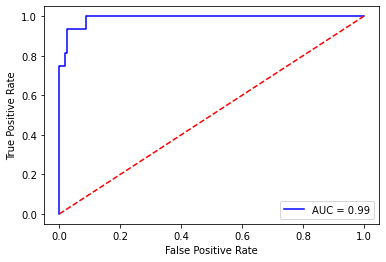

In [9]:
X_train, X_validate, X_test, y_train, y_validate, y_test = split(df)
best_svm = svm_validate(X_train, y_train, X_validate, y_validate)
y_predict = best_svm.predict(X_test)
print(best_svm)
print(classification_report(y_test, y_predict))
print(f'ROC_AUC', roc_auc_score(y_test, y_predict))
draw_roc_curve(best_svm,X_test,y_test)

## Encoding
We then encode some of the categorical data in the dataset to improve the metrics.

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf',
                 SVC(C=100, degree=1, gamma=0.001, probability=True,
                     random_state=2))])
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       114
           1       1.00      0.75      0.86        16

    accuracy                           0.97       130
   macro avg       0.98      0.88      0.92       130
weighted avg       0.97      0.97      0.97       130

ROC_AUC 0.875


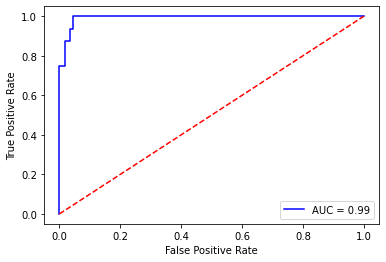

In [10]:
cols = ['location', 'country', 'symptom1', 'symptom2', 'symptom3', 'symptom4', 'symptom5', 'symptom6']
df_encoded = encode(df, cols)
X_train, X_validate, X_test, y_train, y_validate, y_test = split(df_encoded)
best_svm = svm_validate(X_train, y_train, X_validate, y_validate)
y_predict = best_svm.predict(X_test)
print(best_svm)
print(classification_report(y_test, y_predict))
print(f'ROC_AUC', roc_auc_score(y_test, y_predict))
draw_roc_curve(best_svm,X_test,y_test)

## Feature selection
Here we experimentally select features. After some experiments this is the best result. Some features were removed based on their low correlation with the data while others were removed after experimentally testing that their removal improved recall.

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf',
                 SVC(C=100, degree=1, gamma=0.001, probability=True,
                     random_state=2))])
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       114
           1       1.00      0.88      0.93        16

    accuracy                           0.98       130
   macro avg       0.99      0.94      0.96       130
weighted avg       0.98      0.98      0.98       130

ROC_AUC 0.9375


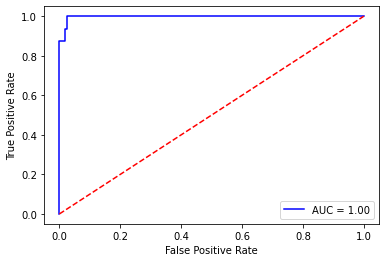

In [11]:
dropped_cols = ['symptom6', 'symptom5', 'symptom4','symptom2']
encoded_cols = ['country','location', 'symptom1', 'symptom3']
df_encoded = encode(df.drop(dropped_cols, axis=1), encoded_cols)
X_train, X_validate, X_test, y_train, y_validate, y_test = split(df_encoded)
best_svm = svm_validate(X_train, y_train, X_validate, y_validate)
y_predict = best_svm.predict(X_test)
print(best_svm)
print(classification_report(y_test, y_predict))
print(f'ROC_AUC', roc_auc_score(y_test, y_predict))
draw_roc_curve(best_svm,X_test,y_test)

## Bagging with Validation
In this section, we utilise a bagging classifier to attempt to improve the recall.

In [12]:
dic = {'clf':[], 'recall':[]}
c_values = [0.1, 1, 10, 100, 1000] 
gamma_values = [1, 0.1, 0.01, 0.001, 0.0001]
degrees = np.arange(1, 11, 1)

parameters = list(itertools.product(c_values, gamma_values, degrees))
for c, gamma, degree in parameters:
    rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(C=c, gamma=gamma, degree=degree, random_state = 2, probability=True))
    ])
    bagging_clf = BaggingClassifier(base_estimator=rbf_kernel_svm_clf, n_estimators=10, random_state=2)
    bagging_clf.fit(X_train, y_train)
    y_pred = bagging_clf.predict(X_validate)
    recall = recall_score(y_validate, y_pred)
    dic['clf'].append(bagging_clf)
    dic['recall'].append(recall)
df_scores = pd.DataFrame(dic)

BaggingClassifier(base_estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('svm_clf',
                                                  SVC(C=10, degree=1,
                                                      gamma=0.01,
                                                      probability=True,
                                                      random_state=2))]),
                  random_state=2)
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       114
           1       1.00      0.62      0.77        16

    accuracy                           0.95       130
   macro avg       0.97      0.81      0.87       130
weighted avg       0.96      0.95      0.95       130

ROC_AUC 0.8125


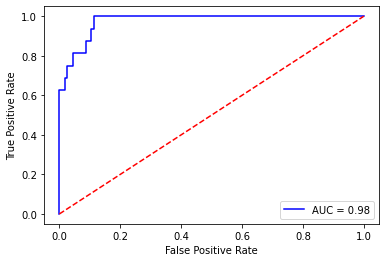

In [13]:
bagging_clf = df_scores.iloc[df_scores['recall'].idxmax(), 0]
y_predict = bagging_clf.predict(X_test)
print(bagging_clf)
print(classification_report(y_test, y_predict))
print(f'ROC_AUC', roc_auc_score(y_test, y_predict))
draw_roc_curve(bagging_clf,X_test,y_test)

## Over sampling
Since the data is imbalanced for the '1' class we utilise a random oversampler to balance the data by duplicating existing data from the '1' class.

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf',
                 SVC(C=0.1, degree=1, gamma=0.1, probability=True,
                     random_state=2))])
              precision    recall  f1-score   support

           0       0.99      0.86      0.92       114
           1       0.48      0.94      0.64        16

    accuracy                           0.87       130
   macro avg       0.74      0.90      0.78       130
weighted avg       0.93      0.87      0.89       130

ROC_AUC 0.8985745614035088


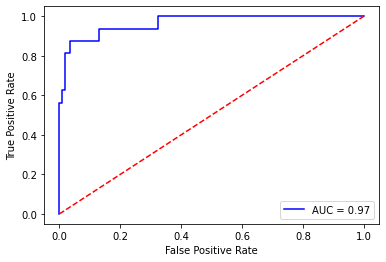

In [14]:
dropped_cols = ['symptom6', 'symptom5', 'symptom4', 'symptom3', 'symptom2']
df_dropped = df.drop(dropped_cols, axis=1)
ros = RandomOverSampler(random_state=42)
X_train, X_validate, X_test, y_train, y_validate, y_test = split(df_dropped)
X_train, y_train= ros.fit_resample(X=X_train, y=y_train)
best_svm = svm_validate(X_train, y_train, X_validate, y_validate)
y_predict = best_svm.predict(X_test)
print(best_svm)
print(classification_report(y_test, y_predict))
print(f'ROC_AUC', roc_auc_score(y_test, y_predict))
draw_roc_curve(best_svm,X_test,y_test)

## Using a Bagging Classifier on Oversampled Data

BaggingClassifier(base_estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('svm_clf',
                                                  SVC(C=0.1, degree=1,
                                                      gamma=0.1,
                                                      random_state=2))]),
                  random_state=2)
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       114
           1       0.52      0.94      0.67        16

    accuracy                           0.88       130
   macro avg       0.75      0.91      0.80       130
weighted avg       0.93      0.88      0.90       130

ROC_AUC 0.9073464912280702


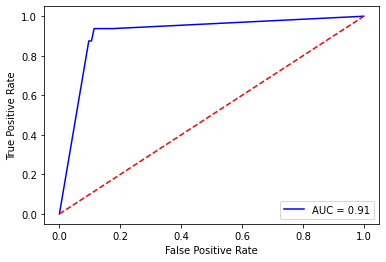

In [15]:
dropped_cols = ['symptom6', 'symptom5', 'symptom4', 'symptom3', 'symptom2']
df_dropped = df.drop(dropped_cols, axis=1)
ros = RandomOverSampler(random_state=42)
X_train, X_validate, X_test, y_train, y_validate, y_test = split(df_dropped)
X_train, y_train= ros.fit_resample(X=X_train, y=y_train)
dic = {'clf':[], 'recall':[]}
c_values = [0.1, 1, 10, 100, 1000] 
gamma_values = [1, 0.1, 0.01, 0.001, 0.0001]
degrees = np.arange(1, 11, 1)

parameters = list(itertools.product(c_values, gamma_values, degrees))
for c, gamma, degree in parameters:
    rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(C=c, gamma=gamma, degree=degree, random_state = 2))
    ])
    bagging_clf = BaggingClassifier(base_estimator=rbf_kernel_svm_clf, n_estimators=10, random_state=2)
    bagging_clf.fit(X_train, y_train)
    y_pred = bagging_clf.predict(X_validate)
    recall = recall_score(y_validate, y_pred)
    dic['clf'].append(bagging_clf)
    dic['recall'].append(recall)
df_scores = pd.DataFrame(dic)
bagging_clf = df_scores.iloc[df_scores['recall'].idxmax(), 0]
y_predict = bagging_clf.predict(X_test)
print(bagging_clf)
print(classification_report(y_test, y_predict))
print(f'ROC_AUC', roc_auc_score(y_test, y_predict))
draw_roc_curve(bagging_clf,X_test,y_test)

## Final Model
We recommend using the model found in the "Feature Selection" section. As it leads to the highest values of recall and a good balance between recall and precsion.

### Model hyperparameters

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf',
                 SVC(C=100, degree=1, gamma=0.001, probability=True,
                     random_state=2))])
                     
### Classification report

              precision    recall  f1-score

           0       0.98      1.00      0.99 
           1       1.00      0.88      0.93  

    accuracy                           0.98
    ROC_AUC                            0.94

# Decision Tree

In [16]:
df = pd.read_csv('data.csv',index_col=0)

## Without Encoding
First we attempt to fit the model without any changes to act as a baseline.

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_features=6, random_state=2)
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       114
           1       0.82      0.88      0.85        16

    accuracy                           0.96       130
   macro avg       0.90      0.92      0.91       130
weighted avg       0.96      0.96      0.96       130

ROC_AUC 0.924342105263158


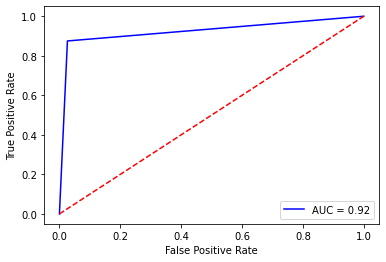

In [17]:
X_train, X_validate, X_test, y_train, y_validate, y_test = split(df)
best_DT = DT_validate(X_train, y_train, X_validate, y_validate)
y_predict = best_DT.predict(X_test)
print(best_DT)
print(classification_report(y_test, y_predict))
print(f'ROC_AUC', roc_auc_score(y_test, y_predict))
draw_roc_curve(best_DT,X_test,y_test)

## Encoding
We then encode some of the categorical data in the dataset to attempt to improve the metrics.

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_features=28, random_state=2)
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       114
           1       0.65      0.69      0.67        16

    accuracy                           0.92       130
   macro avg       0.80      0.82      0.81       130
weighted avg       0.92      0.92      0.92       130

ROC_AUC 0.8174342105263158


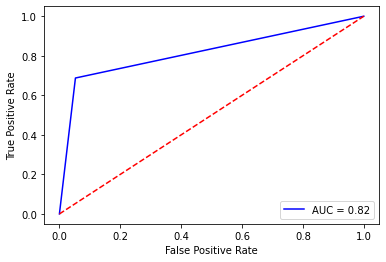

In [18]:
cols = ['location', 'country', 'symptom1', 'symptom2', 'symptom3', 'symptom4', 'symptom5', 'symptom6']
df_encoded = encode(df, cols)
X_train, X_validate, X_test, y_train, y_validate, y_test = split(df_encoded)
best_DT = DT_validate(X_train, y_train, X_validate, y_validate)
y_predict = best_DT.predict(X_test)
print(best_DT)
print(classification_report(y_test, y_predict))
print(f'ROC_AUC', roc_auc_score(y_test, y_predict))
draw_roc_curve(best_DT,X_test,y_test)

Performing one-hot encoding on the data decreases the information gain of each column thus worsening the performance metrics of the model. Thus we use the encoding that was given in the dataset.

## Feature Selection
Here we experimentally select features. After some experiments this is the best result. Some features were removed based on their low correlation with the data while others were removed after experimentally testing that their removal improved recall.

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_features=4, random_state=2)
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       114
           1       0.81      0.81      0.81        16

    accuracy                           0.95       130
   macro avg       0.89      0.89      0.89       130
weighted avg       0.95      0.95      0.95       130

ROC_AUC 0.8930921052631579


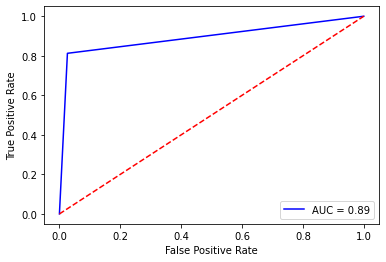

In [19]:
dropped_cols = ['symptom6', 'symptom5', 'symptom4']
df_dropped = df.drop(dropped_cols, axis=1)
X_train, X_validate, X_test, y_train, y_validate, y_test = split(df_dropped)
best_DT = DT_validate(X_train, y_train, X_validate, y_validate)
y_predict = best_DT.predict(X_test)
print(best_DT)
print(classification_report(y_test, y_predict))
print(f'ROC_AUC', roc_auc_score(y_test, y_predict))
draw_roc_curve(best_DT,X_test,y_test)

## Bagging with Validation
In this section, we utilise a bagging classifier to attempt to improve the recall.

In [20]:
dic = {'clf':[], 'recall':[]}
criterion = ['entropy','gini']
splitter = ['best','random']
class_weight = ['balanced', None]
max_features = [i for i in range(1,X_train.shape[1])]
parameters = list(itertools.product(criterion, splitter, class_weight,max_features))
for crit, splitter, weight, max_features in parameters:
    DT = DecisionTreeClassifier(criterion = crit, splitter=splitter, class_weight=weight, random_state = 2, max_features = max_features)
    bagging_clf = BaggingClassifier(base_estimator= DT, random_state=2)
    bagging_clf.fit(X_train, y_train)
    y_pred = bagging_clf.predict(X_validate)
    recall = recall_score(y_validate, y_pred)
    dic['clf'].append(bagging_clf)
    dic['recall'].append(recall)
df_scores = pd.DataFrame(dic)


BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                        criterion='entropy',
                                                        max_features=7,
                                                        random_state=2),
                  random_state=2)
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       114
           1       0.93      0.81      0.87        16

    accuracy                           0.97       130
   macro avg       0.95      0.90      0.92       130
weighted avg       0.97      0.97      0.97       130

ROC_AUC 0.9018640350877193


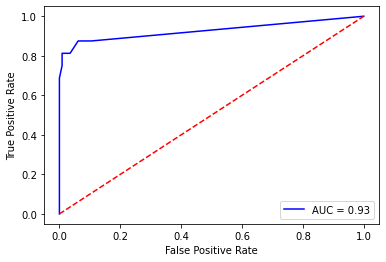

In [21]:
bagging_clf = df_scores.iloc[df_scores['recall'].idxmax(), 0]
y_predict = bagging_clf.predict(X_test)
print(bagging_clf)
print(classification_report(y_test, y_predict))
print(f'ROC_AUC', roc_auc_score(y_test, y_predict))
draw_roc_curve(bagging_clf,X_test,y_test)

## Oversampling
Since the data is imbalanced for the '1' class we utilise a random oversampler to balance the data by duplicating existing data from the '1' class.

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_features=2, random_state=2)
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       114
           1       0.81      0.81      0.81        16

    accuracy                           0.95       130
   macro avg       0.89      0.89      0.89       130
weighted avg       0.95      0.95      0.95       130

ROC_AUC 0.8930921052631579


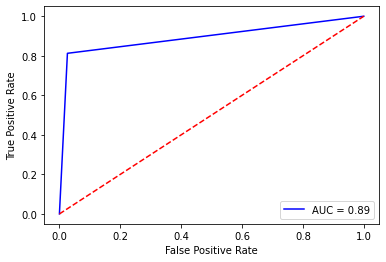

In [22]:
dropped_cols = ['symptom6', 'symptom5', 'symptom4', 'symptom3', 'symptom2']
df_dropped = df.drop(dropped_cols, axis=1)
ros = RandomOverSampler(random_state=42)
X_train, X_validate, X_test, y_train, y_validate, y_test = split(df_dropped)
X_train, y_train= ros.fit_resample(X=X_train, y=y_train)
best_DT = DT_validate(X_train, y_train, X_validate, y_validate)
y_predict = best_DT.predict(X_test)

print(best_DT)
print(classification_report(y_test, y_predict))
print(f'ROC_AUC', roc_auc_score(y_test, y_predict))
draw_roc_curve(best_DT,X_test,y_test)


## Using a Bagging Classifier on Oversampled Data

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                        criterion='entropy',
                                                        max_features=2,
                                                        random_state=2),
                  random_state=2)
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       114
           1       0.93      0.88      0.90        16

    accuracy                           0.98       130
   macro avg       0.96      0.93      0.95       130
weighted avg       0.98      0.98      0.98       130

ROC_AUC 0.9331140350877193


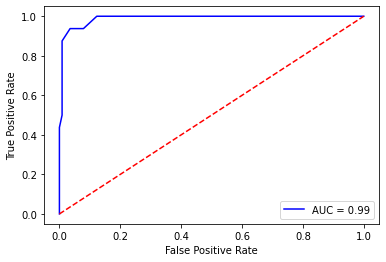

In [23]:
dropped_cols = ['symptom6', 'symptom5', 'symptom4', 'symptom3', 'symptom2']
encoded_cols = []
df_encoded = encode(df.drop(dropped_cols, axis=1), encoded_cols)

ros = RandomOverSampler(random_state=42)
X_train, X_validate, X_test, y_train, y_validate, y_test = split(df_encoded)
X_train, y_train= ros.fit_resample(X=X_train, y=y_train)

dic = {'clf':[], 'recall':[]}
criterion = ['entropy','gini']
splitter = ['best','random']
class_weight = ['balanced', None]
max_features = [i for i in range(1,X_train.shape[1])]

parameters = list(itertools.product(criterion, splitter, class_weight,max_features))

for crit, splitter, weight, max_features in parameters:
    DT = DecisionTreeClassifier(criterion = crit, splitter=splitter, class_weight=weight, random_state = 2, max_features = max_features)
    bagging_clf = BaggingClassifier(base_estimator= DT, random_state=2)
    bagging_clf.fit(X_train, y_train)
    y_pred = bagging_clf.predict(X_validate)
    recall = recall_score(y_validate, y_pred)
    dic['clf'].append(bagging_clf)
    dic['recall'].append(recall)

df_scores = pd.DataFrame(dic)
bagging_clf = df_scores.iloc[df_scores['recall'].idxmax(), 0]

y_predict = bagging_clf.predict(X_test)
print(bagging_clf)
print(classification_report(y_test, y_predict))
print(f'ROC_AUC', roc_auc_score(y_test, y_predict))
draw_roc_curve(bagging_clf,X_test,y_test)

## Final Model

We recommend using the model found in the "Using a Bagging Classifier on Oversampled Data" section. As it leads to the highest values of recall and a good balance between recall and precsion.

### Model hyperparameters

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                        criterion='entropy',
                                                        max_features=2,
                                                        random_state=2), random_state=2)
                     
### Classification report



              precision    recall  f1-score   

           0       0.98      0.99      0.99      
           1       0.93      0.88      0.90        

    accuracy                           0.98       
    roc_auc                            0.93




## Model Comparison

In [31]:
comparision_dic = {
    'Model':['SVM', 'SVM', 'Decision Tree','Decision Tree'],
    'class': ['one', 'zero', 'one', 'zero'],
    'Recall': ['0.88', '1.00','0.88', '0.99'],
    'Precision': ['1.00', '0.98' ,'0.93', '0.98'],
    'f1-score': ['0.93', '0.99', '0.90', '0.99'],
    'roc_auc': ['0.94', '0.94', '0.93', '0.93'],
}

comparision_df = pd.DataFrame(comparision_dic)
comparision_df

,Model,class,Recall,Precision,f1-score,roc_auc
0,SVM,one,0.88,1.00,0.93,0.94
1,SVM,zero,1.00,0.98,0.99,0.94
2,Decision Tree,one,0.88,0.93,0.90,0.93
3,Decision Tree,zero,0.99,0.98,0.99,0.93
